In [1]:
__author__='Xia Wang'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Task 1

In [2]:
data = np.load(os.getenv('PUI2015')+'/HW6/MTA_Fare.npy')

In [3]:
print data.shape
'''
ridetype np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
'''    

(600, 23, 194)


"\nridetype np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',\n            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',\n            'umlim','xbus','stud'])\n"

In [4]:
data = np.where(data != -1, data, np.nan)

In [5]:
# add up all the stations
by_ridetype_sum = np.nansum(data, axis=0)
# add up all ride types
by_station_sum = np.nansum(data, axis=1)

In [6]:
station1 = pd.DataFrame(by_station_sum.T)
station1.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

<function matplotlib.pyplot.show>

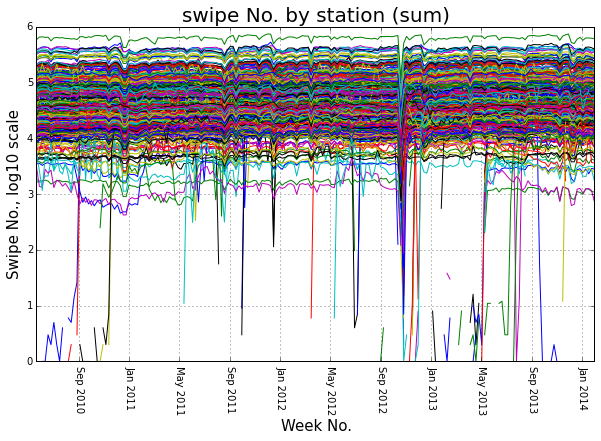

In [7]:
fig1 = plt.figure(figsize=(10,6))
fig1.add_subplot(111)
plt.plot(station1.index, np.log10(station1))
plt.title('swipe No. by station (sum)',fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week No.', fontsize=15)
plt.ylabel('Swipe No., log10 scale', fontsize=15)
plt.grid()
plt.show

In [8]:
ridetype1 = pd.DataFrame(by_ridetype_sum.T)
ridetype1.columns = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
                    'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t','umlim',
                    'xbus','stud']
ridetype1.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

<function matplotlib.pyplot.show>

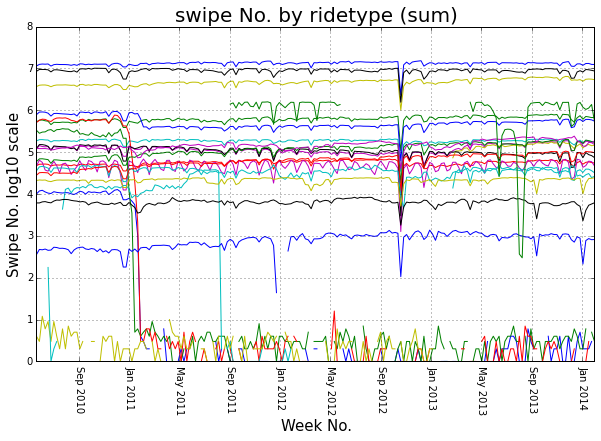

In [9]:
fig1 = plt.figure(figsize=(10,6))
fig1.add_subplot(111)
plt.plot(ridetype1.index, np.log10(ridetype1))
plt.title('swipe No. by ridetype (sum)',fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week No.', fontsize=15)
plt.ylabel('Swipe No. log10 scale', fontsize=15)
plt.grid()
plt.show

In [10]:
by_ridetype_avg = np.nanmean(data, axis=0)
by_station_avg = np.nanmean(data, axis=1)

/Users/eliseowang/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [11]:
# print by_ridetype_avg.shape
# print by_station_avg.shape

In [12]:
ridetype = pd.DataFrame(by_ridetype_avg.T)

In [13]:
ridetype.columns = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
                    'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t','umlim',
                    'xbus','stud']

In [14]:
ridetype.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

In [15]:
station = pd.DataFrame(by_station_avg.T)

In [16]:
station.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

<function matplotlib.pyplot.show>

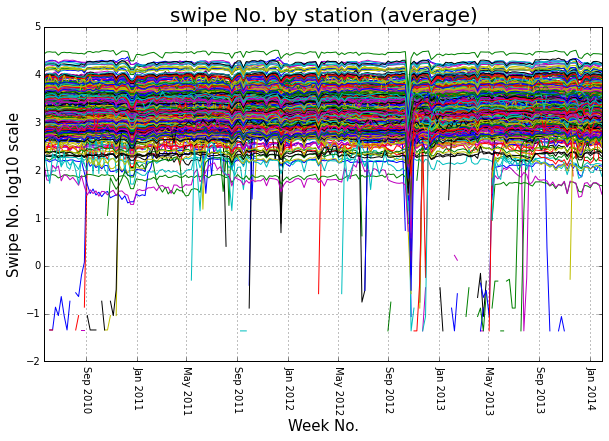

In [17]:
fig1 = plt.figure(figsize=(10,6))
fig1.add_subplot(111)
plt.plot(station.index, np.log10(station))
plt.title('swipe No. by station (average)', fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week No.', fontsize=15)
plt.ylabel('Swipe No. log10 scale', fontsize=15)
plt.grid()
plt.show

<function matplotlib.pyplot.show>

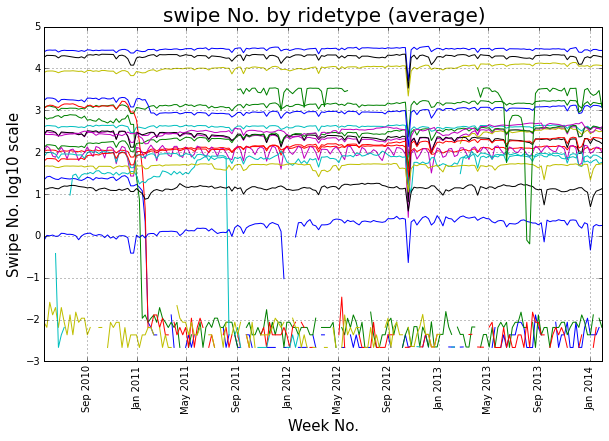

In [18]:
fig1 = plt.figure(figsize=(10,6))
fig1.add_subplot(111)
plt.plot(ridetype.index, np.log10(ridetype))
plt.title('swipe No. by ridetype (average)', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Week No.', fontsize=15)
plt.ylabel('Swipe No. log10 scale', fontsize=15)
plt.grid()
plt.show

## By simply looking at the plots (both by station and by ridetype), we can detect a huge drop in the winter of 2012. I'll detect the event as an outlier using 3 standard deviations from mean as the critical value. And I'll only apply it to the swipe numbers by ridetype (average). The same code can be applied to other datasets.

In [19]:
ridetype_num = pd.DataFrame(by_ridetype_avg.T).convert_objects(convert_numeric=True)

/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [20]:
ridetype_num.loc['sigma'] = ridetype_num.std()
ridetype_num.loc['mean'] = ridetype_num.mean()
ridetype_num.loc['critical min'] = ridetype_num.loc['mean'] - 3.0*ridetype_num.loc['sigma']
ridetype_num.loc['critical max'] = ridetype_num.loc['mean'] + 3.0*ridetype_num.loc['sigma']

In [21]:
# calculate if any value in the dataframe is an outliers
eventsmin = np.where(ridetype_num < ridetype_num.loc['critical min'])
eventsmax = np.where(ridetype_num > ridetype_num.loc['critical max'])[0]

In [22]:
print eventsmin

(array([ 30,  31,  95, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 134, 173, 173, 189, 189, 194, 194, 194, 194, 194, 194,
       194, 194, 194, 194, 194]), array([ 6,  6, 19,  0,  1,  2,  3,  4,  5,  6, 11, 13, 18, 19, 20,  6, 19,
       20, 19, 20,  0,  1,  2,  3,  5,  6, 11, 13, 18, 19, 20]))


In [23]:
events = np.array(eventsmin[0])
np.unique(events)

array([ 30,  31,  95, 126, 134, 173, 189, 194])

## According to the calculation, week 126, 173 189 and 194 have outliers. As we have seen previously in the plots, in week 126 the plot shows a sharp drop. Week 173, 189 are not very obvious on the plots though. As for week 126, the sharp drop was probably caused by Hurricane Sandy when the infrustructure was damaged and the use of metro dropped significantly.

## Task 2

In [24]:
from scipy import stats
import statsmodels.api as sm

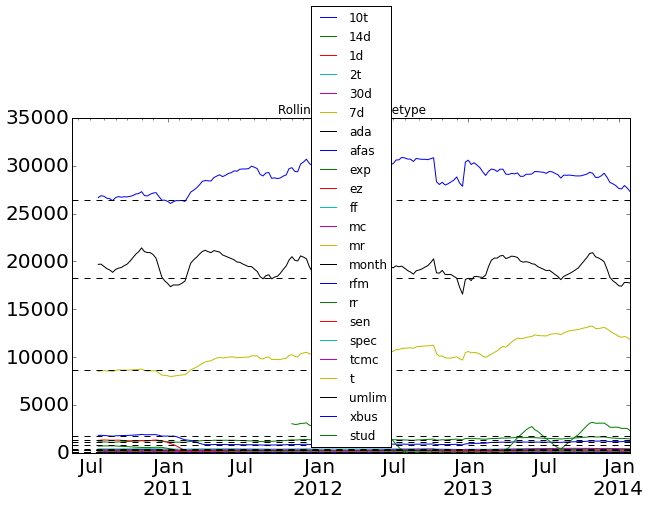

In [48]:
# I've tried different window numbers from 1 to 20 and I think 10 is a good fit.
pd.rolling_mean(ridetype, 10).plot(figsize=(10,6), 
                                   title='Rolling mean of ridetype', fontsize=20)
plt.legend(loc=8)
for x in ridetype.ix['2010-08-06']:
    plt.axhline(x, color='k',linestyle='--')

## 10t shows a growing trend, unlim is almost stable, 7d shows an even more obvious growing trend, and ada type dropped a little. The others are more difficult to detect by eyes. The whole result is shown below

In [64]:
ls1 = pd.rolling_mean(ridetype, 12).dropna().head(10)
ls2 = pd.rolling_mean(ridetype, 12).dropna().tail(10)

In [63]:
# I calculated the rolling mean for the first and last 10 weeks,
# the one by the other, and took the average
ls1.index = np.arange(10)
ls2.index = np.arange(10)
ratio = ls1/ls2
ratio.mean()

10t      1.059771
14d      0.869120
1d       1.042852
2t       1.005811
30d      0.956064
7d       0.813949
ada      1.056366
afas     0.305032
exp      0.924472
ez       1.510246
ff       0.000018
mc       0.648088
mr       0.000015
month    1.336611
rfm      0.730442
rr       0.675629
sen      0.665266
spec     0.975112
tcmc     0.708968
t        1.039908
umlim    1.135261
xbus     0.783629
stud     1.082737
dtype: float64

## The rolling std is shown below

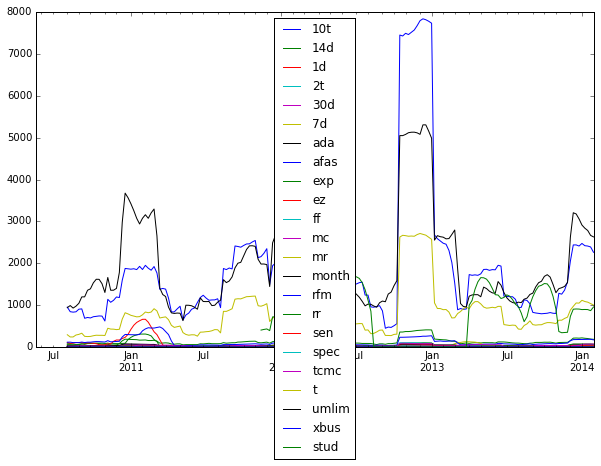

In [41]:
pd.rolling_std(ridetype, 12).plot(figsize=(10,6))
plt.legend(loc=9)

## Task 3

In [ ]:
np.fft.rfftfreq(194, d)